### Рассмотрим зависимость дифференциальной энтропии от логарифма дисперсии

Для начала найдём h(N(0,1)) = 2.030 бит
Получили ожидаемое значение ~2.047 бит


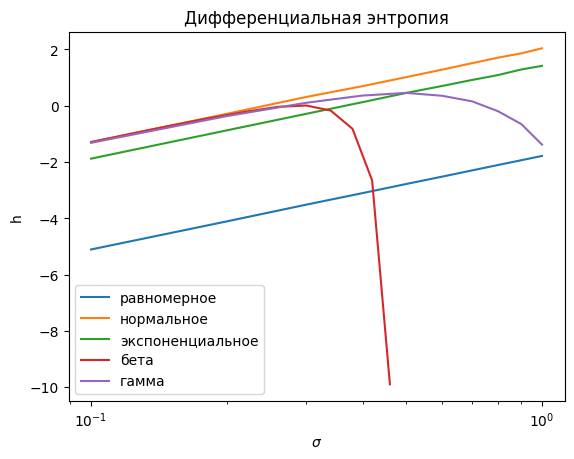

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Базовый класс, задающий распределение непрерывной случайной величины
class Distribution:
    # возвращает sample(массив выборок) размера size
    def __call__(self, size = 1):
        return np.zeros(size)

    # подстраивает параметры распределения под заданные матожидание и дисперсию
    def fit_to_moments(self, mu : float, sigma : float):
        pass

# Равномерное распределение
class UniformDistribution(Distribution):
    def __init__(self, low = -1.0, high = 1.0):
        self.low = low
        self.high = high

    def fit_to_moments(self, mu: float, sigma: float):
        half_size = sigma / (4 * np.sqrt(3))
        self.low = mu - half_size
        self.high = mu + half_size

    def __call__(self, size = 1):
        return np.random.uniform(self.low, self.high, size)

# Нормальное распределение
class NormalDistribution(Distribution):
    def __init__(self, mu = 0.0, sigma = 1.0):
        self.mu = mu
        self.sigma = sigma

    def fit_to_moments(self, mu: float, sigma: float):
        self.mu = mu
        self.sigma = sigma

    def __call__(self, size = 1):
        return np.random.normal(self.mu, self.sigma, size)

# Экспоненциальное распределение: rho(x) = L * e^(-L * x) на [0, +inf)
# Частный случай Gamma-распределения при a = 1, b = 1/L
class ExpDistribution(Distribution):
    def __init__(self, L = 1.0):
        self.L = L

    # игнорирует предписанное матожидание
    def fit_to_moments(self, mu: float, sigma: float):
        self.L = 1 / sigma

    def __call__(self, size = 1):
        return np.random.exponential(1 / self.L, size)

# Beta-распределение: rho(x) = x^(a-1) * (1-x)^(b-1) / Beta(a, b) на [0, 1]
class BetaDistribution(Distribution):
    def __init__(self, alpha = 1.0, beta = 1.0):
        self.alpha = alpha
        self.beta = beta

    # mu = a / (a + b), sigma^2 = ab / (a + b)^2 / (a + b + 1)
    # 0 < mu < 1, 0 < sigma^2 < mu(1 - mu)
    def fit_to_moments(self, mu: float, sigma: float):
        A = mu*(1 - mu) / (sigma*sigma) - 1
        self.alpha = mu * A
        self.beta = (1 - mu) * A

    def __call__(self, size = 1):
        return np.random.beta(self.alpha, self.beta, size)

# Gamma-распределение: rho(x) = x^(a-1) * e^(-x/b) / (b^a * Gamma(a)) на [0, +inf)
class GammaDistribution(Distribution):
    def __init__(self, alpha = 1.0, beta = 1.0):
        self.alpha = alpha
        self.beta = beta

    # mu = ab, sigma^2 = ab^2
    def fit_to_moments(self, mu: float, sigma: float):
        self.beta = sigma * sigma / mu
        self.alpha = mu / self.beta

    def __call__(self, size = 1):
        return np.random.gamma(self.alpha, self.beta, size)

# Численно находит плотности распределения в заданных точках
def get_density(sample : np.ndarray, k : int):
    N = len(sample)
    # Матрица расстояний
    distances = np.abs(sample[:, np.newaxis] - sample[np.newaxis, :])
    sorted_distances = np.sort(distances, axis=1)
    # расстояние до k-ой ближайшей точки
    epsilon_k = sorted_distances[:, k]
    rho = k / (N * 2 * epsilon_k)
    return rho

# находит дифференциальную энтропию как -E[log(rho(x))] методом Монте-Карло, учитывая k-го соседа для вычисления плотности
def h(sample : np.ndarray, k : int):
    return -float(np.sum(np.log2(get_density(sample, k)))) / len(sample)

def plot_the_entropy(dist : Distribution, label : str, scale = 10.0):
    xs = []
    ys = []
    for shift in range(10):
        sigma = 0.1 + shift / scale
        xs.append(sigma)
        dist.fit_to_moments(0.5, sigma)
        ys.append(h(dist(10000), 200))
    plt.plot(xs, ys, label=label)

normal = NormalDistribution()
print(f"Для начала найдём h(N(0,1)) = {h(normal(10000), 200):.3f} бит")
print(f"Получили ожидаемое значение ~{0.5*np.log2(2*np.pi*np.e):.3f} бит")

plot_the_entropy(UniformDistribution(), "равномерное")
plot_the_entropy(NormalDistribution(), "нормальное")
plot_the_entropy(ExpDistribution(), "экспоненциальное")
plot_the_entropy(BetaDistribution(), "бета", 25.0)
plot_the_entropy(GammaDistribution(), "гамма")
plt.xlabel("$\\sigma$")
plt.xscale("log")
plt.ylabel("h")
plt.title("Дифференциальная энтропия")
plt.legend()
plt.show()

#### **Вывод:** для равномерного, нормального и экспоненциального распределений видим ожидаемую зависимость $h = A log(\sigma) + B$, но кроме того для бета и гамма распределений зависимость оказалась нелинейной и имеет даже экстремум. А это значит, что дифференциальная энтропия не всегда не убывает с ростом дисперсии.

#### Кроме того на этом графике хорошо видно, что нормальное распределение имеет наибольшую энтропию при заданной дисперсии.

#### Резкое падение энтропии у бета распределения легко объяснить. Мы рассматриваем распределения с матожиданием 0.5 при этом для бета распределения будет верно $\alpha = \beta$ и при стремлении дисперсии к $0.25$ плтность распределения напоминает U, то есть сосредоточена в двух точках.

### Теперь рассмотрим взаимную информацию в канале с АБГШ при нормальном и равномерном входных распределениях с разлиными энергиями

In [ ]:
# Y = C + N, N ~ Norm(0, sigma^2)
class AWGNChannel:
    def __init__(self, sigma : float):
        self.N = NormalDistribution(0, sigma)
        self.sigma = sigma

    # вычисление взаимной информации I(C,Y)
    def get_I(self, C : Distribution):
        return h(self.get_Y(C, 10000), 200) - 0.5*np.log2(2*np.pi*np.e*self.sigma*self.sigma)

    # возвращает sample выходного распределения размера size
    def get_Y(self, C : Distribution, size = 1):
        return C(size) + self.N(size)
    
channel = AWGNChannel(1)
print("Возьмём канал со стандартным АБГШ N(0,1) и на вход подадим тоже нормальное распределение с энергией Es")
print("Численно найдём взаимную информацию I(Y,C) и сравним с известным результатом для нормального распределения символов")
for Es in [10, 25, 100, 150, 200]:
    print(f"Es = {Es}: {channel.get_I(NormalDistribution(0, np.sqrt(Es)))} ~ {0.5*np.log2(1 + Es)}")

Возьмём канал со стандартным АБГШ N(0,1) и на вход подадим тоже нормальное распределение с энергией Es
Численно найдём взаимную информацию I(Y,C) и сравним с известным результатом для нормального распределения символов
Es = 10: 1.6989401712485233 ~ 1.7297158093186487
Es = 25: 2.3364182912724174 ~ 2.350219859070546
Es = 100: 3.3233090319337584 ~ 3.3291057413758973
Es = 150: 3.6091481649541444 ~ 3.6192023696625393
Es = 200: 3.825099532688275 ~ 3.8255258455894645


#### Мы получили ожидаемые результаты.

#### Теперь попробуем подать на вход равномерное распределение с теми же энергиями Es.

In [20]:
for Es in [10, 25, 100, 150, 200]:
    uni = UniformDistribution()
    uni.fit_to_moments(0, np.sqrt(Es))
    print(f"Es = {Es}: {channel.get_I(uni)} < {channel.get_I(NormalDistribution(0, np.sqrt(Es)))}")

Es = 10: 0.028983724485132534 < 1.7104408030443925
Es = 25: 0.094238889616443 < 2.3364479860617853
Es = 100: 0.37079016709547785 < 3.311984447415012
Es = 150: 0.48864554856376374 < 3.601948575616833
Es = 200: 0.614866888970937 < 3.803857280562474


#### Как и ожидалось при использовании распределения отличного от нормального через канал прошло меньше информации при той же энергии.